# **Train MetaA2C Model on Reversal ABC Task**

This notebook trains a Meta-Actor-Critic (MetaA2C) model on the reversal ABC task where:
- Stimulus A: Always rewarded in pre-reversal, never in post-reversal
- Stimulus B: Never rewarded in pre-reversal, 50% rewarded in post-reversal
- Stimulus C: Random reward (50% probability, doesn't reverse)

The MetaA2C model uses a shared RNN backbone with feedforward actor and critic heads, enabling the agent to maintain memory across timesteps and use previous actions and rewards as input.

Training approach:
- Train sequentially through phases: first pre-reversal, then post-reversal
- Track metrics continuously across the entire sequence
- Visualise with reversal points marked on the plots

In [97]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pickle
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

from cog_nn.tasks.reversal_envs import ReversalABCEnv, load_reversal_abc_data
from cog_nn.models import RNNActorCritic
from cog_nn.agents import MetaA2CAgent

# Import plot style settings
import cog_nn.plot_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
save_path = Path("/Users/pmccarthy/Documents/modelling_results/december_2025_a2c/single_reversal")
task_data_path = Path("/Users/pmccarthy/Documents/cogNN/task_data")
task = "reversal_abc"

---
Load Task Dataset


In [99]:
# Load reversal ABC task data
data_path = Path(task_data_path, f"{task}.pkl")

try:
    state_sequence, reward_sequence, reversal_mask, phase_boundaries, state_map = load_reversal_abc_data(data_path)
    print(f"Loaded data from {data_path}")
    print(f"State sequence shape: {state_sequence.shape}")
    print(f"Reward sequence shape: {reward_sequence.shape}")
    if phase_boundaries:
        print(f"Phase boundaries: {phase_boundaries}")
        print(f"Reversal points (timesteps): {phase_boundaries.get('reversal_points', [])}")
except FileNotFoundError:
    print(f"Data file not found at {data_path}")
    print("Please run task_generation.ipynb first to generate the data")
    raise
except ValueError:
    # Handle old format
    try:
        state_sequence, reward_sequence, reversal_mask = load_reversal_abc_data(data_path)
        phase_boundaries = None
        print(f"Loaded data (without phase boundaries)")
    except:
        raise

# Create environment
env = ReversalABCEnv(
    state_sequence, 
    reward_sequence, 
    reversal_mask,
    reward_lick=1.0,      # Higher reward for correct lick
    lick_no_reward=-2,  # Less negative for incorrect lick
    no_lick=0.0           # No change for no lick
)
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"\nEnvironment created:")
print(f"State size: {state_size}")
print(f"Action size: {action_size}")
print(f"Total timesteps: {len(state_sequence)}")

Loaded data from /Users/pmccarthy/Documents/cogNN/task_data/reversal_abc.pkl
State sequence shape: (16000, 5)
Reward sequence shape: (16000,)
Phase boundaries: {'reversal_points': [8000], 'pre_reversal': {'start': 0, 'end': 8000}, 'post_reversal': {'start': 8000, 'end': 16000}}
Reversal points (timesteps): [8000]

Environment created:
State size: 5
Action size: 2
Total timesteps: 16000


In [100]:
phase_boundaries

{'reversal_points': [8000],
 'pre_reversal': {'start': 0, 'end': 8000},
 'post_reversal': {'start': 8000, 'end': 16000}}

---
Define Model and Agent


In [108]:
# Model hyperparameters
hidden_size = 128  # RNN hidden size
learning_rate = 0.0005
gamma = 0  # Discount factor

# Create MetaA2C agent (includes shared RNN backbone with actor and critic heads)
agent = MetaA2CAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size)

# Add optimizer and gamma to the model (required by update method)
agent.model.optimizer = Adam(agent.model.parameters(), lr=learning_rate)
agent.model.gamma = gamma

print("Model initialised:")
print(f"Gamma (discount factor): {agent.model.gamma}")
print(f"MetaA2C Agent: {agent.model}")


policy_clip_param = 0.25  # Minimum action probability

Models initialised:
Actor: Actor(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)
Critic: Critic(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


---
Training Setup


In [102]:
phase_boundaries

{'reversal_points': [8000],
 'pre_reversal': {'start': 0, 'end': 8000},
 'post_reversal': {'start': 8000, 'end': 16000}}

In [103]:
# Training parameters
batch_size = 1  # Update every N steps

# Get phase boundaries
if phase_boundaries:
    pre_start = phase_boundaries['pre_reversal']['start']
    pre_end = phase_boundaries['pre_reversal']['end']
    post_start = phase_boundaries['post_reversal']['start']
    post_end = phase_boundaries['post_reversal']['end']
    reversal_points = phase_boundaries.get('reversal_points', [])
else:
    # Fallback: estimate from reversal_mask
    pre_end = np.sum(reversal_mask == 0) * 2  # Each trial = 2 timesteps
    pre_start = 0
    post_start = pre_end
    post_end = len(state_sequence)
    reversal_points = [pre_end]

print(f"Training setup:")
print(f"Pre-reversal phase: timesteps {pre_start} to {pre_end}")
print(f"Post-reversal phase: timesteps {post_start} to {post_end}")
print(f"Reversal points: {reversal_points}")

# Track metrics during training (continuous across sequence)
metrics = {
    'lick_probs': {'A': [], 'B': [], 'C': []},
    'values': {'A': [], 'B': [], 'C': []},
    'rewards': [],
    'timesteps': [],
    'reward_timesteps': [],
    'timesteps_A': [],
    'timesteps_B': [],
    'timesteps_C': []
}

Training setup:
Pre-reversal phase: timesteps 0 to 8000
Post-reversal phase: timesteps 8000 to 16000
Reversal points: [8000]


---
Training Loop

In [104]:
# Set model to training mode
agent.model.train()

# Initialize previous action and reward tracking
prev_action = torch.zeros(action_size)  # One-hot encoding
prev_reward = torch.tensor(0.0)

# Reset hidden state
agent.reset_hidden_state()

# Reset environment
obs, info = env.reset()

# Track states, actions, rewards for batch update
states_batch = []
prev_actions_batch = []
prev_rewards_batch = []
actions_batch = []
rewards_batch = []
next_states_batch = []
next_prev_actions_batch = []
next_prev_rewards_batch = []
dones_batch = []

print("Starting training...")
print(f"Phase 1: Pre-reversal (timesteps {pre_start} to {pre_end})")

# Train on pre-reversal phase
for t_idx in range(pre_start, pre_end):
    if t_idx % 50 == 0:
        print(f"  Timestep {t_idx}/{pre_end}")
    
    # Get current state
    state = torch.from_numpy(obs).float()
    
    # Select action (MetaA2C requires prev_action and prev_reward)
    action, action_prob, value = agent.select_action(state, prev_action, prev_reward, deterministic=False, policy_clip=policy_clip_param)
    
    # Step environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Get actual environment timestep (absolute timestep in overall sequence)
    env_timestep = info.get('timestep', t_idx)
    
    # Store for batch update
    states_batch.append(obs)
    prev_actions_batch.append(prev_action.numpy())
    prev_rewards_batch.append(prev_reward.item())
    actions_batch.append(action)
    rewards_batch.append(reward)
    next_states_batch.append(next_obs)
    # Create next prev_action (one-hot) and prev_reward
    next_prev_action = torch.zeros(action_size)
    next_prev_action[action] = 1.0
    next_prev_actions_batch.append(next_prev_action.numpy())
    next_prev_rewards_batch.append(reward)
    dones_batch.append(done)
    
    # Track metrics by stimulus
    state_idx = np.argmax(obs)
    if state_idx == 0:  # A
        if action == 0:  # lick
            metrics['lick_probs']['A'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['A'].append(1 - action_prob)
        metrics['values']['A'].append(value)
        metrics['timesteps_A'].append(env_timestep)
    elif state_idx == 1:  # B
        if action == 0:  # lick
            metrics['lick_probs']['B'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['B'].append(1 - action_prob)
        metrics['values']['B'].append(value)
        metrics['timesteps_B'].append(env_timestep)
    elif state_idx == 2:  # C
        if action == 0:  # lick
            metrics['lick_probs']['C'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['C'].append(1 - action_prob)
        metrics['values']['C'].append(value)
        metrics['timesteps_C'].append(env_timestep)
    
    # Track rewards only when reward is available
    if info.get('reward_available', False):
        metrics['rewards'].append(reward)  # Actual reward from env.step()
        metrics['reward_timesteps'].append(env_timestep)
    
    obs = next_obs
    
    # Update prev_action and prev_reward for next iteration
    prev_action = next_prev_action
    prev_reward = torch.tensor(reward, dtype=torch.float32)
    
    # Batch update
    if len(states_batch) >= batch_size:
        agent.update(
            torch.from_numpy(np.array(states_batch)).float(),
            torch.from_numpy(np.array(prev_actions_batch)).float(),
            torch.from_numpy(np.array(prev_rewards_batch)).float(),
            torch.from_numpy(np.array(actions_batch)).long(),
            torch.from_numpy(np.array(rewards_batch)).float(),
            torch.from_numpy(np.array(next_states_batch)).float(),
            torch.from_numpy(np.array(next_prev_actions_batch)).float(),
            torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
            torch.from_numpy(np.array(dones_batch)).float()
        )
        # Clear batch
        states_batch = []
        prev_actions_batch = []
        prev_rewards_batch = []
        actions_batch = []
        rewards_batch = []
        next_states_batch = []
        next_prev_actions_batch = []
        next_prev_rewards_batch = []
        dones_batch = []

print(f"\nPhase 2: Post-reversal (timesteps {post_start} to {post_end})")

# Train on post-reversal phase
for t_idx in range(post_start, post_end):
    if (t_idx - post_start) % 50 == 0:
        print(f"  Timestep {t_idx}/{post_end}")
    
    # Get current state
    state = torch.from_numpy(obs).float()
    
    # Select action (MetaA2C requires prev_action and prev_reward)
    action, action_prob, value = agent.select_action(state, prev_action, prev_reward, deterministic=False, policy_clip=policy_clip_param)
    
    # Step environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Get actual environment timestep (absolute timestep in overall sequence)
    env_timestep = info.get('timestep', t_idx)
    
    # Store for batch update
    states_batch.append(obs)
    prev_actions_batch.append(prev_action.numpy())
    prev_rewards_batch.append(prev_reward.item())
    actions_batch.append(action)
    rewards_batch.append(reward)
    next_states_batch.append(next_obs)
    # Create next prev_action (one-hot) and prev_reward
    next_prev_action = torch.zeros(action_size)
    next_prev_action[action] = 1.0
    next_prev_actions_batch.append(next_prev_action.numpy())
    next_prev_rewards_batch.append(reward)
    dones_batch.append(done)
    
    # Track metrics by stimulus
    state_idx = np.argmax(obs)
    if state_idx == 0:  # A
        if action == 0:  # lick
            metrics['lick_probs']['A'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['A'].append(1 - action_prob)
        metrics['values']['A'].append(value)
        metrics['timesteps_A'].append(env_timestep)
    elif state_idx == 1:  # B
        if action == 0:  # lick
            metrics['lick_probs']['B'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['B'].append(1 - action_prob)
        metrics['values']['B'].append(value)
        metrics['timesteps_B'].append(env_timestep)
    elif state_idx == 2:  # C
        if action == 0:  # lick
            metrics['lick_probs']['C'].append(action_prob)
        elif action == 1:  # no-lick
            metrics['lick_probs']['C'].append(1 - action_prob)
        metrics['values']['C'].append(value)
        metrics['timesteps_C'].append(env_timestep)
    
    # Track rewards only when reward is available
    if info.get('reward_available', False):
        metrics['rewards'].append(reward)  # Actual reward from env.step()
        metrics['reward_timesteps'].append(env_timestep)
    
    obs = next_obs
    
    # Update prev_action and prev_reward for next iteration
    prev_action = next_prev_action
    prev_reward = torch.tensor(reward, dtype=torch.float32)
    
    # Batch update
    if len(states_batch) >= batch_size:
        agent.update(
            torch.from_numpy(np.array(states_batch)).float(),
            torch.from_numpy(np.array(prev_actions_batch)).float(),
            torch.from_numpy(np.array(prev_rewards_batch)).float(),
            torch.from_numpy(np.array(actions_batch)).long(),
            torch.from_numpy(np.array(rewards_batch)).float(),
            torch.from_numpy(np.array(next_states_batch)).float(),
            torch.from_numpy(np.array(next_prev_actions_batch)).float(),
            torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
            torch.from_numpy(np.array(dones_batch)).float()
        )
        # Clear batch
        states_batch = []
        prev_actions_batch = []
        prev_rewards_batch = []
        actions_batch = []
        rewards_batch = []
        next_states_batch = []
        next_prev_actions_batch = []
        next_prev_rewards_batch = []
        dones_batch = []

# Final update with remaining batch
if len(states_batch) > 0:
    agent.update(
        torch.from_numpy(np.array(states_batch)).float(),
        torch.from_numpy(np.array(prev_actions_batch)).float(),
        torch.from_numpy(np.array(prev_rewards_batch)).float(),
        torch.from_numpy(np.array(actions_batch)).long(),
        torch.from_numpy(np.array(rewards_batch)).float(),
        torch.from_numpy(np.array(next_states_batch)).float(),
        torch.from_numpy(np.array(next_prev_actions_batch)).float(),
        torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
        torch.from_numpy(np.array(dones_batch)).float()
    )

print("\nTraining complete!")
print(f"Total timesteps trained: {pre_end - pre_start + post_end - post_start}")
print(f"Total rewards collected: {len(metrics['rewards'])}")


Starting training...
Phase 1: Pre-reversal (timesteps 0 to 8000)
  Timestep 0/8000
  Timestep 50/8000
  Timestep 100/8000
  Timestep 150/8000
  Timestep 200/8000
  Timestep 250/8000
  Timestep 300/8000
  Timestep 350/8000
  Timestep 400/8000
  Timestep 450/8000
  Timestep 500/8000
  Timestep 550/8000
  Timestep 600/8000
  Timestep 650/8000
  Timestep 700/8000
  Timestep 750/8000
  Timestep 800/8000
  Timestep 850/8000
  Timestep 900/8000
  Timestep 950/8000
  Timestep 1000/8000
  Timestep 1050/8000
  Timestep 1100/8000
  Timestep 1150/8000
  Timestep 1200/8000
  Timestep 1250/8000
  Timestep 1300/8000
  Timestep 1350/8000
  Timestep 1400/8000
  Timestep 1450/8000
  Timestep 1500/8000
  Timestep 1550/8000
  Timestep 1600/8000
  Timestep 1650/8000
  Timestep 1700/8000
  Timestep 1750/8000
  Timestep 1800/8000
  Timestep 1850/8000
  Timestep 1900/8000
  Timestep 1950/8000
  Timestep 2000/8000
  Timestep 2050/8000
  Timestep 2100/8000
  Timestep 2150/8000
  Timestep 2200/8000
  Timestep 22

In [105]:
# Verify reward delivery logic
print("\n=== Reward Delivery Verification ===")
# Check: rewards are tracked at timesteps where reward is available
rewards_array = np.array(metrics['rewards'])

# Rewards are tracked when reward_available=True, storing actual reward from env.step()
print(f"Total rewards tracked (at available timesteps): {len(rewards_array)}")
print(f"Mean reward: {np.mean(rewards_array):.4f}")
print(f"Max reward: {np.max(rewards_array):.4f}")
print(f"Min reward: {np.min(rewards_array):.4f}")

# Check reward availability in sequence
if 'reward_sequence' in locals():
    # Count rewards available at outcome states (odd indices)
    reward_available_count = np.sum(reward_sequence[1::2] > 0)
    print(f"\nReward available at {reward_available_count} outcome states (odd timesteps)")
    print(f"Rewards tracked: {len(rewards_array)}")
    print(f"\nNote: Rewards are tracked at timesteps where reward is available.")
    print(f"The stored reward value is the actual reward output by env.step()")
    print(f"(which may be positive if agent licked, negative if agent licked but no reward, or 0 if no lick).")



=== Reward Delivery Verification ===
Total rewards tracked (at available timesteps): 4038
Mean reward: 0.4898
Max reward: 1.0000
Min reward: 0.0000

Reward available at 4038 outcome states (odd timesteps)
Rewards tracked: 4038

Note: Rewards are tracked at timesteps where reward is available.
The stored reward value is the actual reward output by env.step()
(which may be positive if agent licked, negative if agent licked but no reward, or 0 if no lick).


---
Visualise Results


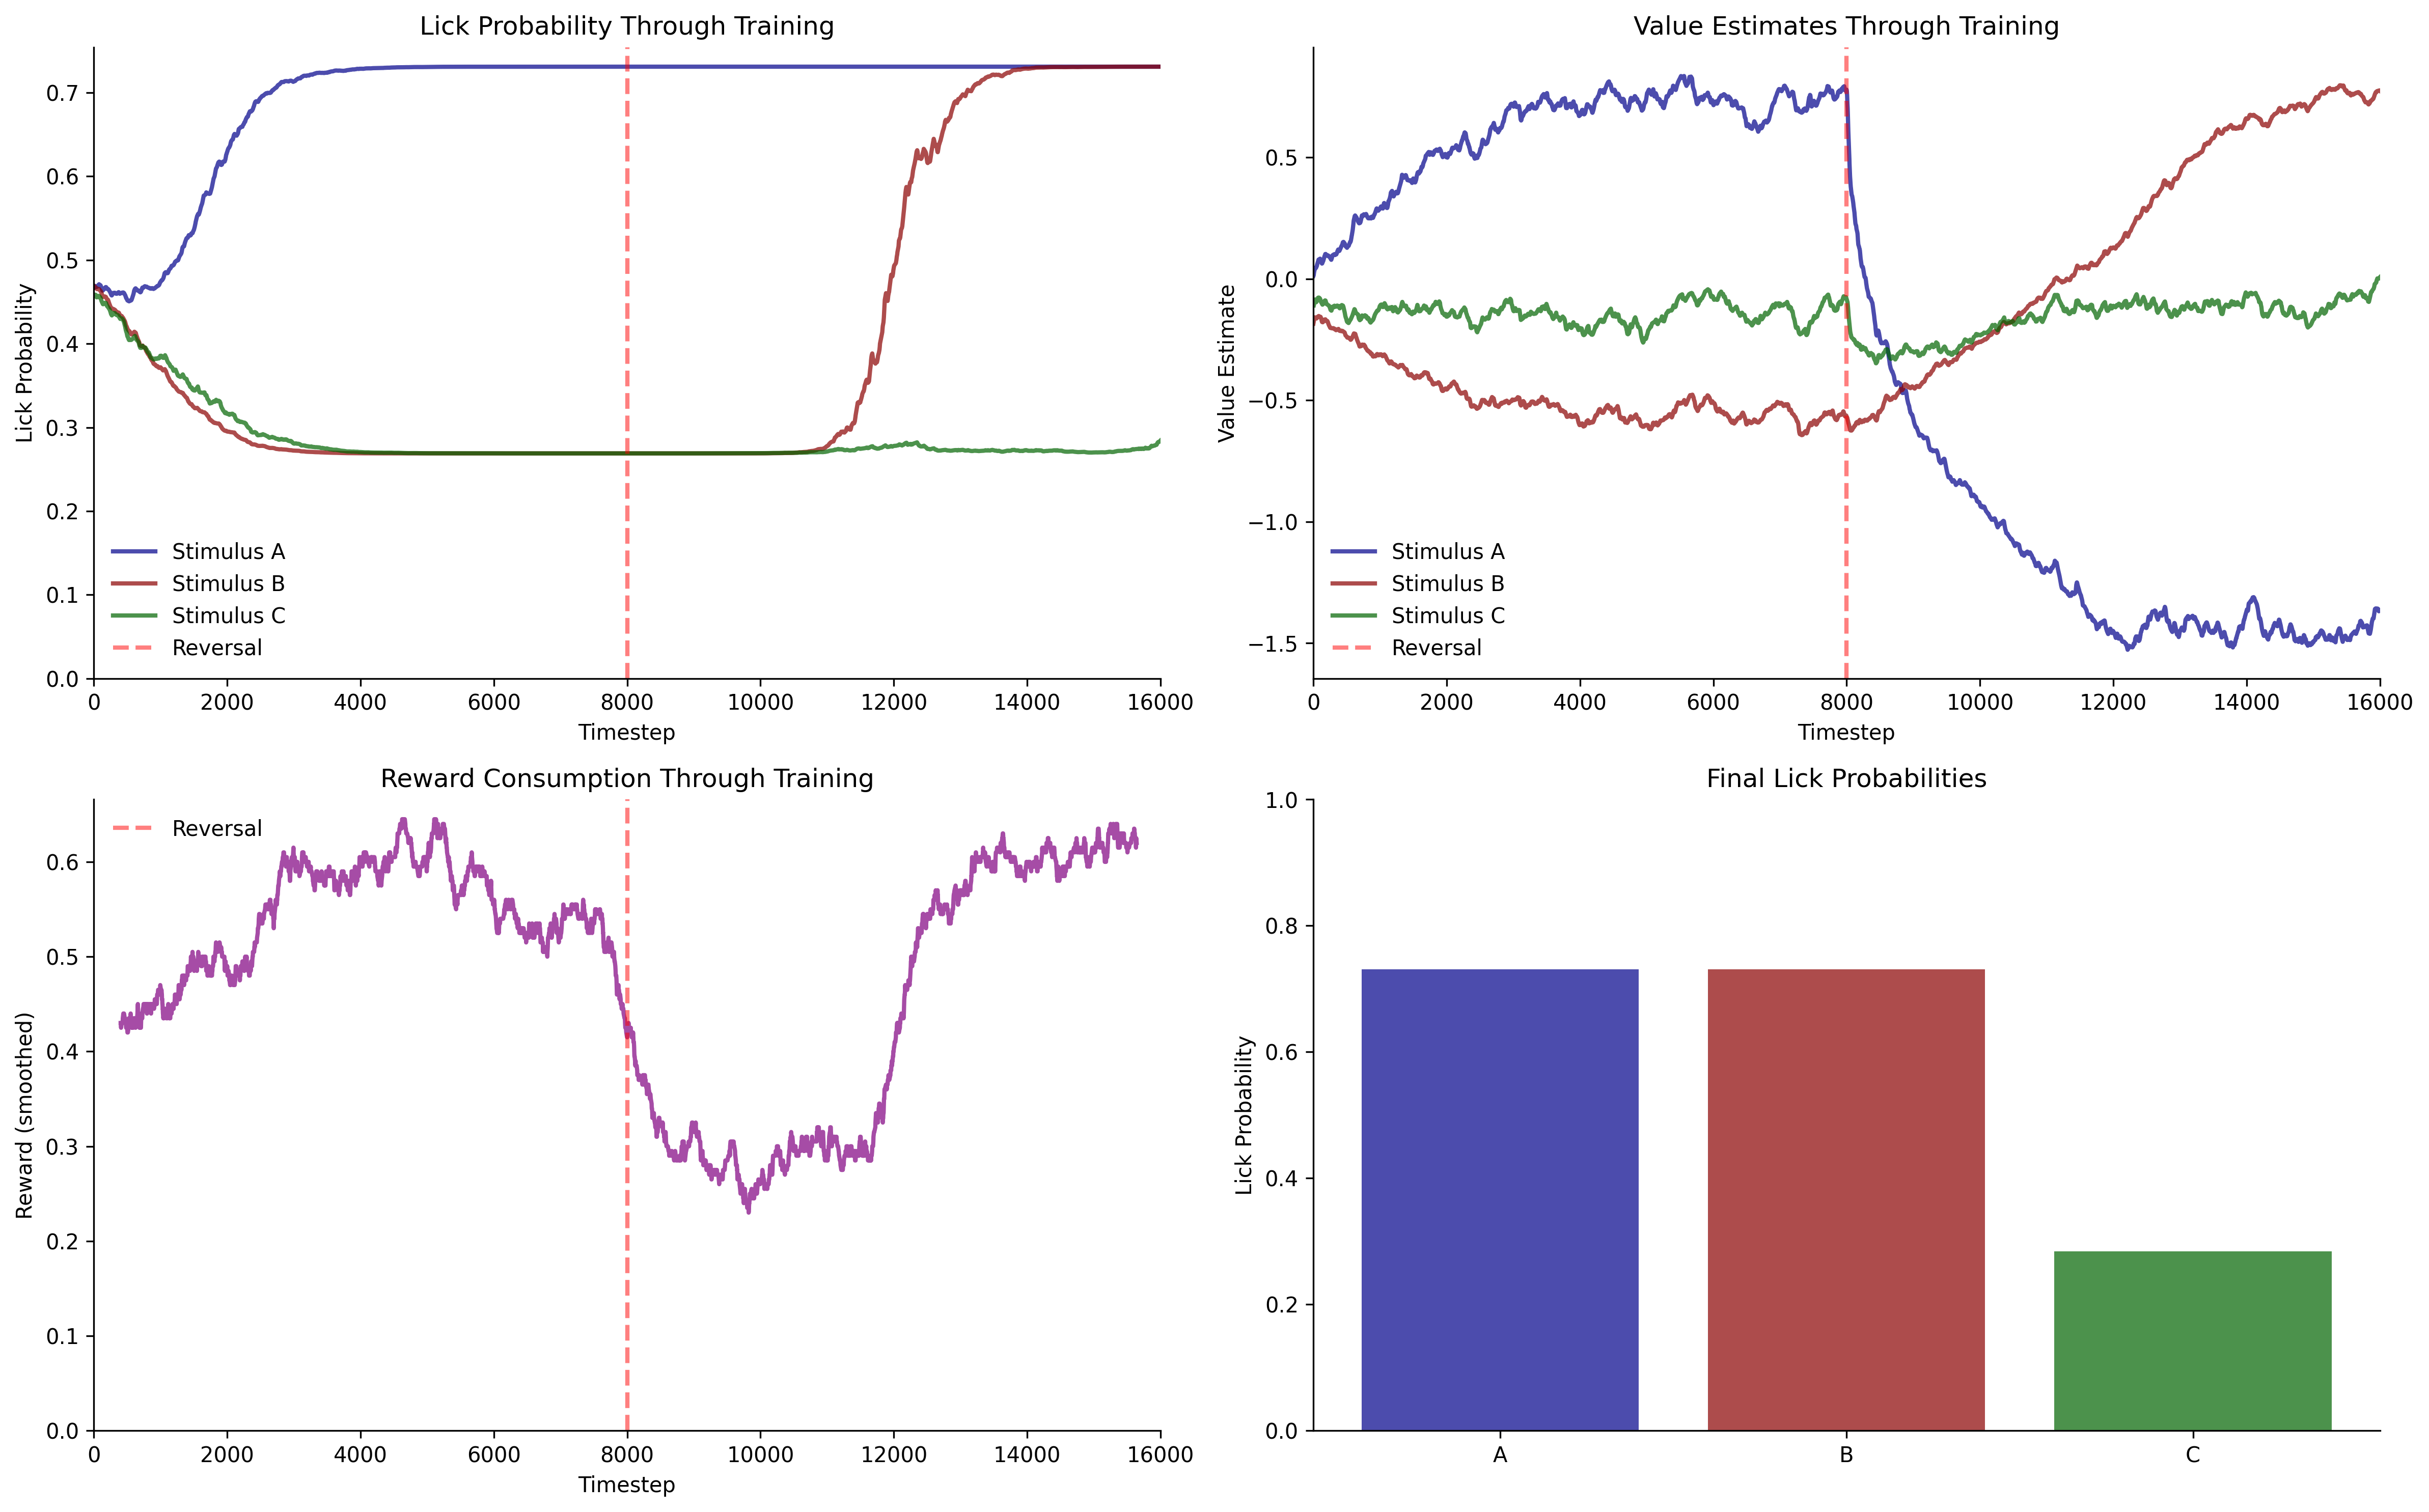

Visualisation complete!

Summary:
Mean reward: 0.4898
Final lick prob A: 0.731
Final lick prob B: 0.731
Final lick prob C: 0.284


In [106]:
# Convert metrics to numpy arrays
lick_probs_A = np.array(metrics['lick_probs']['A'])
lick_probs_B = np.array(metrics['lick_probs']['B'])
lick_probs_C = np.array(metrics['lick_probs']['C'])
values_A = np.array(metrics['values']['A'])
values_B = np.array(metrics['values']['B'])
values_C = np.array(metrics['values']['C'])
rewards = np.array(metrics['rewards'])

# Get timesteps for plotting
# Get timesteps for plotting (absolute timesteps from overall sequence)
timesteps_A = np.array(metrics.get('timesteps_A', []))
timesteps_B = np.array(metrics.get('timesteps_B', []))
timesteps_C = np.array(metrics.get('timesteps_C', []))

# Create visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Lick probabilities over training (with reversal points)
ax = axes[0, 0]
if len(timesteps_A) == len(lick_probs_A) and len(timesteps_A) > 0:
    ax.plot(timesteps_A, lick_probs_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(timesteps_B) == len(lick_probs_B) and len(timesteps_B) > 0:
    ax.plot(timesteps_B, lick_probs_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(timesteps_C) == len(lick_probs_C) and len(timesteps_C) > 0:
    ax.plot(timesteps_C, lick_probs_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Lick Probability')
ax.set_title('Lick Probability Through Training')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 2: Value estimates over training
ax = axes[0, 1]
if len(timesteps_A) == len(values_A) and len(timesteps_A) > 0:
    ax.plot(timesteps_A, values_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(timesteps_B) == len(values_B) and len(timesteps_B) > 0:
    ax.plot(timesteps_B, values_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(timesteps_C) == len(values_C) and len(timesteps_C) > 0:
    ax.plot(timesteps_C, values_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Value Estimate')
ax.set_title('Value Estimates Through Training')
ax.legend()
# ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 3: Rewards over time (smoothed)
# Get reward timesteps
reward_timesteps = np.array(metrics.get('reward_timesteps', np.arange(len(rewards))))
ax = axes[1, 0]
# Smooth rewards with moving average
window_size = 200
if len(rewards) > window_size:
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    # Get reward timesteps
    reward_timesteps = np.array(metrics.get('reward_timesteps', np.arange(len(rewards))))
    # For mode='valid', np.convolve returns len(rewards) - window_size + 1 elements
    # The smoothed values correspond to timesteps starting from window_size//2
    start_idx = window_size // 2
    smoothed_timesteps = reward_timesteps[start_idx:start_idx + len(smoothed_rewards)]
    ax.plot(smoothed_timesteps, smoothed_rewards, linewidth=2, color='purple', alpha=0.7)
else:
    ax.plot(rewards, linewidth=1, color='purple', alpha=0.5)

# Mark reversal points
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Reward (smoothed)')
ax.set_title('Reward Consumption Through Training')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 4: Final performance comparison
ax = axes[1, 1]
# Get final values for each stimulus
final_lick_probs = []
stimuli = []
colors = []
if len(lick_probs_A) > 0:
    final_lick_probs.append(lick_probs_A[-1])
    stimuli.append('A')
    colors.append('darkblue')
if len(lick_probs_B) > 0:
    final_lick_probs.append(lick_probs_B[-1])
    stimuli.append('B')
    colors.append('darkred')
if len(lick_probs_C) > 0:
    final_lick_probs.append(lick_probs_C[-1])
    stimuli.append('C')
    colors.append('darkgreen')

if len(final_lick_probs) > 0:
    bars = ax.bar(stimuli, final_lick_probs, color=colors, alpha=0.7)
    ax.set_ylabel('Lick Probability')
    ax.set_title('Final Lick Probabilities')
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualisation complete!")
print(f"\nSummary:")
print(f"Mean reward: {np.mean(rewards):.4f}")
if len(lick_probs_A) > 0:
    print(f"Final lick prob A: {lick_probs_A[-1]:.3f}")
if len(lick_probs_B) > 0:
    print(f"Final lick prob B: {lick_probs_B[-1]:.3f}")
if len(lick_probs_C) > 0:
    print(f"Final lick prob C: {lick_probs_C[-1]:.3f}")

fig.savefig(save_path / "a2c_reversal_abc_training_results.png")

In [107]:
# Create save directory if it doesn't exist
save_path.mkdir(parents=True, exist_ok=True)
# Save trained models
torch.save(agent.model.state_dict(), save_path / "a2c_actor_reversal_abc_multi.pth")
, save_path / "a2c_critic_reversal_abc_multi.pth ")
# Save params
params = {
    "hidden_size": hidden_size,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "batch_size": batch_size,
    "state_map": state_map,
}
with open(save_path / "meta_a2c_reversal_abc_params.pkl", "wb") as f:
    pickle.dump(params, f)  
print(f"\nModels and parameters saved to {save_path}")
# Save summary plot
fig.savefig(save_path / "meta_a2c_reversal_abc_training_results.png")


Models and parameters saved to /Users/pmccarthy/Documents/modelling_results/december_2025_a2c/single_reversal
